# Chat Agent with Function Calling

In this lesson, we'll use `ChatGenerator` components to build chat agents. These Generators can handle messages from _User_, _Agent_, _System_ or _Function_ roles.

We can equip these Generators with tools in the form of functions. A tool can be an external API, a simple function, or even a Haystack pipeline (e.g. a RAG pipelines that accesses your dataset).

The LLM decides when and how to call a function.

### Preliminaries

Since we will use the `OpenAIGenerator` component, we need to make the correspondig API key accessible via environment.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### Build RAG Pipeline as a Function

In [2]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

template = """
Answer the questions based on the given context.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer:
"""

rag_pipeline = Pipeline()

rag_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
rag_pipeline.add_component("llm", OpenAIGenerator())

rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)

In [3]:
from haystack import Document

def rag_pipeline_func(query: str):
    documents = [
        Document(content="My name is Jean and I live in Paris."),
        Document(content="My name is Mark and I live in Berlin."),
        Document(content="My name is Giorgio and I live in Rome."),
        Document(content="My name is Marta and I live in Madrid."),
        Document(content="My name is Harry and I live in London."),
    ]

    result = rag_pipeline.run({"prompt_builder": {"question": query, "documents": documents}})
    return {"reply": result["llm"]["replies"][0]}

### Create a Weather Function and simulated Weather Data

In [4]:
WEATHER_INFO = {
    "Berlin": {"weather": "mostly sunny", "temperature": 7, "unit": "celsius"},
    "Paris": {"weather": "mostly cloudy", "temperature": 8, "unit": "celsius"},
    "Rome": {"weather": "sunny", "temperature": 14, "unit": "celsius"},
    "Madrid": {"weather": "sunny", "temperature": 10, "unit": "celsius"},
    "London": {"weather": "cloudy", "temperature": 9, "unit": "celsius"},
}

def get_current_weather(location: str):
    if location in WEATHER_INFO:
        return WEATHER_INFO[location]
    else:
        return {"weather": "sunny", "temperature": 70, "unit": "fahrenheit"}

### Define Tools for the Generator

In [5]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "rag_pipeline_func",
            "description": "Get information about where people live",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
                    }
                },
                "required": ["query"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {"type": "string", "description": "The city"}
                },
                "required": ["location"],
            }
        }
    }
]

### Create an OpenAIChatGenerator

In [6]:
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage

chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo", generation_kwargs={'tools': tools})
replies = chat_generator.run(messages=[ChatMessage.from_user("Where does Mark live?")])

print(replies)

{'replies': [ChatMessage(content='[{"id": "call_yMqRfj5BmvdO4pkY4yC0sNVI", "function": {"arguments": "{\\"query\\":\\"Where does Mark live?\\"}", "name": "rag_pipeline_func"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-3.5-turbo-0125', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {'completion_tokens': 20, 'prompt_tokens': 104, 'total_tokens': 124}})]}


### Create a Function Caller

In [12]:
from pprint import pprint
from haystack_experimental.components.tools import OpenAIFunctionCaller

function_caller = OpenAIFunctionCaller(available_functions={"rag_pipeline_func": rag_pipeline_func,
                                                            "get_current_weather": get_current_weather})

results = function_caller.run(messages=replies['replies'])
pprint(results["function_replies"])

[ChatMessage(content='[{"id": "call_yMqRfj5BmvdO4pkY4yC0sNVI", "function": '
                     '{"arguments": "{\\"query\\":\\"Where does Mark '
                     'live?\\"}", "name": "rag_pipeline_func"}, "type": '
                     '"function"}]',
             role=<ChatRole.ASSISTANT: 'assistant'>,
             name=None,
             meta={'finish_reason': 'tool_calls',
                   'index': 0,
                   'model': 'gpt-3.5-turbo-0125',
                   'usage': {'completion_tokens': 20,
                             'prompt_tokens': 104,
                             'total_tokens': 124}}),
 ChatMessage(content='{"reply": "Mark lives in Berlin."}',
             role=<ChatRole.FUNCTION: 'function'>,
             name='rag_pipeline_func',
             meta={}),
 ChatMessage(content='{"reply": "Mark lives in Berlin."}',
             role=<ChatRole.FUNCTION: 'function'>,
             name='rag_pipeline_func',
             meta={})]


### Create a Chat Agent Pipeline

Here, we need a new component: the `BranchJoiner` combines messages from multiple component outputs into a single stream, allowing messages from both the user and function calls to be fed into the generator.

In [13]:
from typing import List
from haystack.components.joiners import BranchJoiner

message_collector = BranchJoiner(List[ChatMessage])
chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo", generation_kwargs={'tools': tools})
function_caller = OpenAIFunctionCaller(available_functions={"rag_pipeline_func": rag_pipeline_func, 
                                                            "get_current_weather": get_current_weather})

chat_agent = Pipeline()
chat_agent.add_component("message_collector", message_collector)
chat_agent.add_component("generator", chat_generator)
chat_agent.add_component("function_caller", function_caller)

chat_agent.connect("message_collector", "generator.messages")
chat_agent.connect("generator", "function_caller")
chat_agent.connect("function_caller.function_replies", "message_collector")

🚅 Components
  - message_collector: BranchJoiner
  - generator: OpenAIChatGenerator
  - function_caller: OpenAIFunctionCaller
🛤️ Connections
  - message_collector.value -> generator.messages (List[ChatMessage])
  - generator.replies -> function_caller.messages (List[ChatMessage])
  - function_caller.function_replies -> message_collector.value (List[ChatMessage])

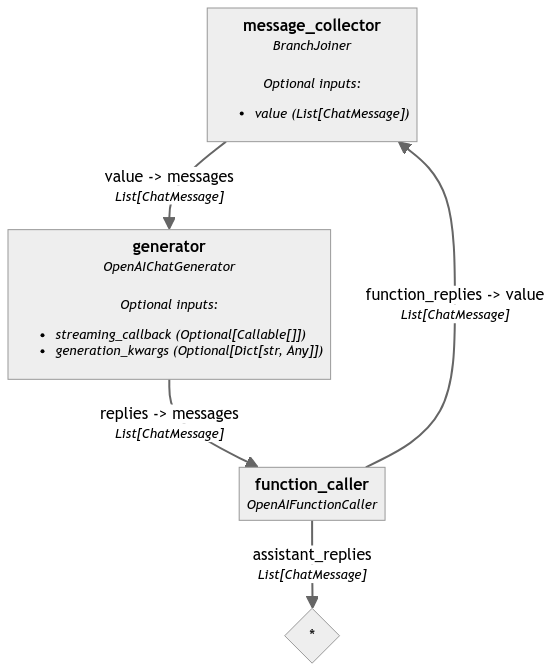

In [9]:
chat_agent.show()Run the following code only in a standalone `jupyter notebook` environment, not within VS Code.

Run the following code only in a standalone `jupyter notebook` environment, not within VS Code.

In [18]:
messages = [
    ChatMessage.from_system(
        """If needed, break down the user's question into simpler questions and follow-up questions that you can use with your tools.
        Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."""
    )
]
while True:
    user_input = input("INFO: Type 'exit' or 'quit' to stop\n")
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    messages.append(ChatMessage.from_user(user_input))
    response = chat_agent.run({"message_collector": {"value": messages}})
    messages.extend(response['function_caller']['assistant_replies'])
    
    print(response['function_caller']['assistant_replies'][0].content)

INFO: Type 'exit' or 'quit' to stop
 quit


### Create a Gradio Chat App

Gradio is an open-source Python package that allows you to quickly build a demo or web application for your machine learning model, API, or any arbitrary Python function. You can then share a link to your demo or web application in just a few seconds using Gradio's built-in sharing features. No JavaScript, CSS, or web hosting experience needed!

In [20]:
import gradio as gr 

In [21]:
messages = [
        ChatMessage.from_system(
            """If needed, break down the user's question to simpler questions and follow-up questions that you can use with your tools.
            Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."""
        )
    ]
def chat(message, history): 
    messages.append(ChatMessage.from_user(message))
    response = chat_agent.run({"message_collector": {"value": messages}})
    messages.extend(response['function_caller']['assistant_replies'])
    return response['function_caller']['assistant_replies'][0].content

In [22]:
demo = gr.ChatInterface(
    fn=chat,
    examples=[
        "Can you tell me where Giorgio lives?",
        "What's the weather like in Madrid?",
        "Who lives in London?",
        "What's the weather like where Mark lives?",
    ],
    title="Ask me about weather or where people live!",
)
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://5ec55c8f20d3718558.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
